## Neuroinformatics Project 1: MRI upscaling


## Imports


In [7]:
import os, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torch.optim as optim
from torch.optim import lr_scheduler


from tempfile import TemporaryDirectory

import torch.backends.cudnn as cudnn

import nibabel as nib
from nilearn import plotting



from extract_slices import (
    # load_nifti,
    slice_to_base64,
    base64_to_slice,
    volume_to_submission_rows,
    create_submission_df,
    nifti_to_submission_rows
)

# import metric
from metric_pt2 import compute_ms_ssim
# import extract_slices


from tqdm import tqdm 

device = "cpu"
# if torch.backends.mps.is_available():
#     device = "mps"
if torch.cuda.is_available():
    device = "cuda"
    cudnn.benchmark = True
    
print("device:", device)




# Configuration
CONFIG = {
    "SEED": 42,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "BATCH_SIZE": 2,
    "LR": 2e-4,
    "WEIGHT_DECAY": 1e-5,
    "NUM_EPOCHS":7,
    # "NUM_EPOCHS":40,
    # "PATIENCE":5,
    "PATCH_SIZE": (96, 96, 96),
    "PATHS": {
        "TRAIN": "./train/",
        "TEST": "./test/",
        "CHECKPOINT": "./runs/checkpoint_final",
    },
}



# Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed(CONFIG["SEED"])
print(f"Running on: {CONFIG['DEVICE']}")

device: cuda
Running on: cuda


### normalize mri


In [8]:
def normalize_numpy(x: np.ndarray) -> np.ndarray:
    """Normalize array to [0, 1] range."""
    x_min, x_max = x.min(), x.max()
    if x_max - x_min > 0:
        return (x - x_min) / (x_max - x_min)
    return np.zeros_like(x)


def normalize_tensor(tensor):
    # Emergency Fix: Clip top 1% to prevent intensity squashing
    v_min = tensor.min()
    v_max = np.percentile(
        tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor, 99.5
    )
    tensor = torch.clamp(tensor, v_min, v_max)
    return (tensor - v_min) / (v_max - v_min + 1e-8)

In [9]:
def load_nifti(path, normalize=True):
    """
    Load a NIfTI file and return the data array.

    Args:
        path: Path to .nii.gz file

    Returns:
        3D numpy array (x, y, z)
    """
    img = nib.load(path).get_fdata()

    if normalize:
        # print(type(img))
        img = normalize_numpy(img)

    return img

In [10]:
def display_nifti(img):
    """
    Display a NIfTI file give fdata().

    Args:
        img: fdata associated with a nifti file
    """

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.imshow(img[img.shape[0] // 2, :, :].T, cmap="gray", origin="lower")
    plt.title("Middle Slice")
    plt.axis("off")

    plt.tight_layout()

    plt.show()

In [11]:
# PROJECT_DIR = "N:/OneDrive - Youngstown State University/3. NYU/25-26/Spring 2026/Neuroinformatics/Projects/Project 1"
PROJECT_DIR = "./"

TRAIN_DIR = os.path.join(PROJECT_DIR, "train/")
TEST_DIR = os.path.join(PROJECT_DIR, "test/")

HF_TRAIN = os.path.join(TRAIN_DIR, "high_field/")
LF_TRAIN = os.path.join(TRAIN_DIR, "low_field/")

LF_TEST = os.path.join(TEST_DIR, "low_field/")

TRAIN_GROUND_TRUTH_PATH = os.path.join(PROJECT_DIR, "train.csv")

# Synthetic dataset

SYNTHETIC_HF = os.path.join(PROJECT_DIR, "simulated_data/HR/")
SYNTHETIC_LF = os.path.join(PROJECT_DIR, "simulated_data/LR/")


print(HF_TRAIN)
print(SYNTHETIC_HF)

./train/high_field/
./simulated_data/HR/


In [12]:
ground_truth_df = pd.read_csv(TRAIN_GROUND_TRUTH_PATH)

ground_truth_df.head()

,row_id,ground_truth
0,sample_001_slice_000,UEsDBC0AAAAIAAAAIQCRRkEa//////////8JABQAc2xpY2...
1,sample_001_slice_001,UEsDBC0AAAAIAAAAIQCGlxaq//////////8JABQAc2xpY2...
2,sample_001_slice_002,UEsDBC0AAAAIAAAAIQBbPb4m//////////8JABQAc2xpY2...
3,sample_001_slice_003,UEsDBC0AAAAIAAAAIQCpeNev//////////8JABQAc2xpY2...
4,sample_001_slice_004,UEsDBC0AAAAIAAAAIQBOZi+L//////////8JABQAc2xpY2...


## Trial image loading


### Project Data


In [13]:
def load_nifti_pair(sample_id):

    LF_sample_path = os.path.join(LF_TRAIN, f"{sample_id}_lowfield.nii")
    HF_sample_path = os.path.join(HF_TRAIN, f"{sample_id}_highfield.nii")

    return {"lowfield": LF_sample_path, "highfield": HF_sample_path}

In [14]:
sample_id = "sample_001"

sample_path_pair = load_nifti_pair(sample_id)

for sample_path in sample_path_pair.items():
    volume = load_nifti(sample_path[1])

    # volume = normalize_mri(volume)

    print(volume)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0.     

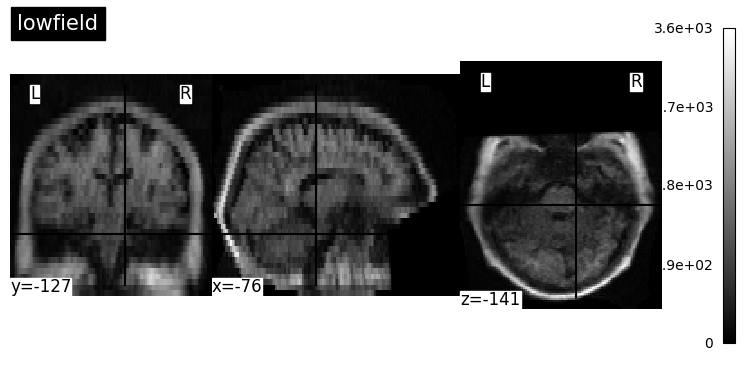

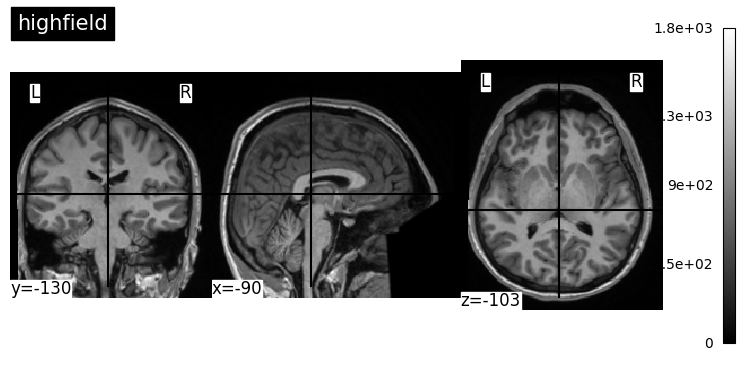

In [15]:
for sample_path in sample_path_pair.items():
    plotting.plot_img(sample_path[1], title=sample_path[0])

## Trilinear interpolation


In [16]:
def prepare_input(low_field_path, target_shape=(179, 221, 200)):
    # 1. Load the NIfTI file
    img_nifti = nib.load(low_field_path)
    # print(f"Low-field shape: {img_nifti.shape}")   # Should be (112, 138, 40)
    img_data = img_nifti.get_fdata()
    affine = img_nifti.affine

    # 2. Convert to PyTorch tensor [Batch, Channel, H, W, D]
    tensor = torch.from_numpy(img_data).float().unsqueeze(0).unsqueeze(0)

    # print(f"Tensor Shape: {tensor.shape}")

    # 3. Upsample to match High-Field dimensions
    # 'trilinear' is essential for 3D data to keep it smooth
    upsampled = F.interpolate(
        tensor, size=target_shape, mode="trilinear", align_corners=True
    )

    return upsampled.squeeze(0), affine  # Returns [1, 179, 221, 200] and the affine

In [17]:
def plot_image_trio(path_pair):
    # Test it on one file
    low_path = list(path_pair.items())[0][1]
    high_path = list(path_pair.items())[1][1]

    if os.path.exists(low_path) and os.path.exists(high_path):

        high_nifti = nib.load(high_path)
        target_shape = high_nifti.get_fdata().shape
        print(f"target_shape:{target_shape}")

        processed_tensor, original_affine = prepare_input(low_path, target_shape)

        data_array = processed_tensor.detach().cpu().numpy().squeeze()

        low_shape = nib.load(low_path).shape
        scale_factors = np.array(low_shape) / np.array(data_array.shape)

        new_affine = original_affine.copy()
        new_affine[:3, :3] = original_affine[:3, :3] * scale_factors

        viz_img = nib.Nifti1Image(data_array, new_affine)

        # 1. Plot the Upsampled Image first and capture the display object
        # (We plot this one first or capture it so we can use its coordinates for the others)
        upsampled_display = plotting.plot_img(
            viz_img,
            title="Upsampled Low-Field MRI",
            display_mode="ortho",
            colorbar=True,
        )

        # 2. Extract the automatically selected cut coordinates (x, y, z)
        # These are the world coordinates chosen by nilearn for the upsampled image
        ref_coords = upsampled_display.cut_coords

        # 3. Plot the Target High-Field using the same coordinates
        # We pass 'ref_coords' to cut_coords to force the exact same view
        plotting.plot_img(
            high_nifti,
            title="Target High-Field",
            display_mode="ortho",
            cut_coords=ref_coords,
        )

        # Optional: You can also sync the original low-field to these coordinates
        # for a perfect 3-way comparison:
        plotting.plot_img(
            low_path,
            title="Original Low-Field",
            display_mode="ortho",
            cut_coords=ref_coords,
        )

        plotting.show()

target_shape:(179, 221, 200)


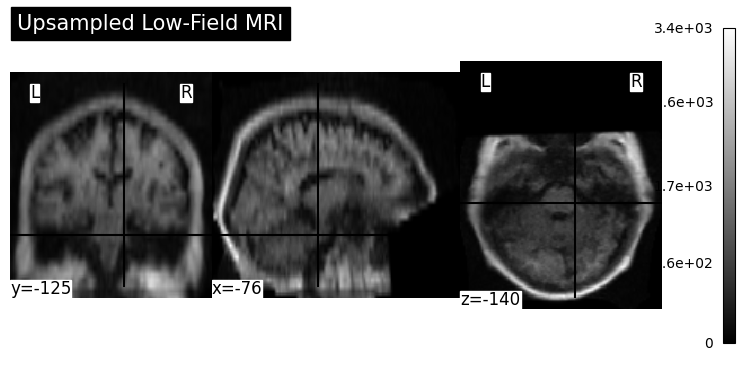

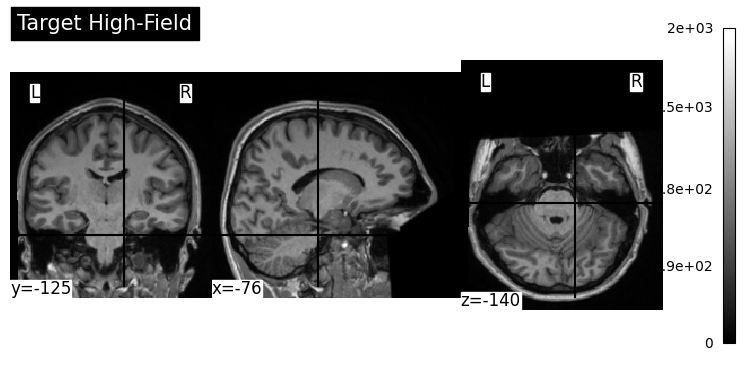

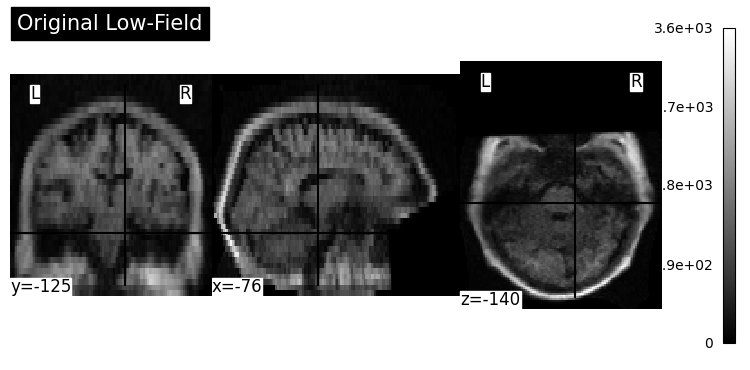

In [18]:
plot_image_trio(sample_path_pair)

## Datasets


In [19]:
class MRIPatchDataset(Dataset):
    def __init__(
        self,
        low_paths,
        high_paths,
        patches_per_vol=16,
        patch_size=96,
        transforms=None,
        # target_shape=(179, 221, 200),
    ):
        self.patches_per_vol = patches_per_vol
        self.patch_size = patch_size
        self.transforms = transforms
        self.data = []

        self.target_shape = (1, 1, 1)  # Will overwrite with new target shape

        print(
            "Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)"
        )

        for l_path, h_path in zip(low_paths, high_paths):
            # 2. Load High-Field ONCE

            fdata = nib.load(h_path).get_fdata()

            self.target_shape = fdata.shape
            # print(f"target_shape: {target_shape}")

            high_vol = torch.from_numpy(fdata).float().unsqueeze(0)

            # 1. Load and Upsample Low-Field ONCE
            # prepare_input should return tensor (C, D, H, W) or (C, H, W, D)
            low_vol, _ = prepare_input(l_path, target_shape=self.target_shape)

            # 3. Normalize ONCE
            low_vol = normalize_tensor(low_vol)
            high_vol = normalize_tensor(high_vol)

            # Store in list
            self.data.append({"low": low_vol, "high": high_vol})

    def __len__(self):
        return len(self.data) * self.patches_per_vol

    def __getitem__(self, idx):
        # Map the continuous index to a specific volume
        vol_idx = idx // self.patches_per_vol

        # Retrieve pre-loaded volumes from RAM
        low_vol = self.data[vol_idx]["low"]
        high_vol = self.data[vol_idx]["high"]

        # Get volume dimensions (C, D, H, W)
        _, d, h, w = low_vol.shape

        valid_patch_found = False
        max_attempts = 50  # Give it more chances to find tissue

        # Ensure the patch isn't just empty space
        for _ in range(max_attempts):
            d_start = np.random.randint(0, d - self.patch_size)
            h_start = np.random.randint(0, h - self.patch_size)
            w_start = np.random.randint(0, w - self.patch_size)

            # Extract Patch
            low_patch = low_vol[
                :,
                d_start : d_start + self.patch_size,
                h_start : h_start + self.patch_size,
                w_start : w_start + self.patch_size,
            ]

            # Direct defense against SSIM nan: Ensure sufficient variance and signal
            if low_patch.mean() > 0.05 and low_patch.var() > 1e-4:
                valid_patch_found = True
                break

        # FALLBACK: If we somehow failed 50 times, grab the exact center of the volume.
        # This guarantees we never pass a pure black patch to the model.
        if not valid_patch_found:
            d_start = (d - self.patch_size) // 2
            h_start = (h - self.patch_size) // 2
            w_start = (w - self.patch_size) // 2

            low_patch = low_vol[
                :,
                d_start : d_start + self.patch_size,
                h_start : h_start + self.patch_size,
                w_start : w_start + self.patch_size,
            ]

        # Extract the exact same region for the high-field target
        high_patch = high_vol[
            :,
            d_start : d_start + self.patch_size,
            h_start : h_start + self.patch_size,
            w_start : w_start + self.patch_size,
        ]

        # Apply MONAI Augmentations (Rotation, Flip, etc.)
        if self.transforms:
            data_dict = self.transforms({"low": low_patch, "high": high_patch})
            return data_dict["low"], data_dict["high"]

        return low_patch, high_patch

    # def __getitem__(self, idx):
    #     # Map the continuous index to a specific volume
    #     vol_idx = idx // self.patches_per_vol

    #     # Retrieve pre-loaded volumes from RAM
    #     low_vol = self.data[vol_idx]["low"]
    #     high_vol = self.data[vol_idx]["high"]

    #     # Get volume dimensions (C, D, H, W)
    #     # Note: Assuming dims are (1, 179, 221, 200) based on your description
    #     _, d, h, w = low_vol.shape

    #     # Ensure patch fits inside volume
    #     # We subtract patch_size so we don't index out of bounds

    #     # Inside __getitem__ before Extract Patch
    #     # Ensure the patch isn't just empty space
    #     for _ in range(10):  # Try 10 times to find a "brainy" patch
    #         d_start = np.random.randint(0, d - self.patch_size)
    #         h_start = np.random.randint(0, h - self.patch_size)
    #         w_start = np.random.randint(0, w - self.patch_size)

    #         # Extract Patch
    #         low_patch = low_vol[
    #             :,
    #             d_start : d_start + self.patch_size,
    #             h_start : h_start + self.patch_size,
    #             w_start : w_start + self.patch_size,
    #         ]
    #         if low_patch.mean() > 0.1:  # Basic threshold for brain tissue
    #             break

    #     high_patch = high_vol[
    #         :,
    #         d_start : d_start + self.patch_size,
    #         h_start : h_start + self.patch_size,
    #         w_start : w_start + self.patch_size,
    #     ]

    #     # Apply MONAI Augmentations (Rotation, Flip, etc.)
    #     if self.transforms:
    #         # MONAI usually expects a dict input for MapTransforms
    #         data_dict = self.transforms({"low": low_patch, "high": high_patch})
    #         return data_dict["low"], data_dict["high"]

    #     return low_patch, high_patch

In [20]:
## Uncomment for Project Data
low_field_paths = [os.path.join(LF_TRAIN, p) for p in os.listdir(LF_TRAIN)]
high_field_paths = [os.path.join(HF_TRAIN, p) for p in os.listdir(HF_TRAIN)]

# test_low_field_paths = [os.path.join(LF_TEST, p) for p in os.listdir(LF_TEST)]

## Uncomment for Synthetic Data
# low_field_paths = [os.path.join(SYNTHETIC_LF, p) for p in os.listdir(SYNTHETIC_LF)]
# high_field_paths = [os.path.join(SYNTHETIC_HF, p) for p in os.listdir(SYNTHETIC_HF)]


# print(len(low_field_paths))

cap_size = min(18, len(low_field_paths))

train_size = min(14, cap_size)
val_size = cap_size - train_size


from monai.transforms import (
    Compose,
    RandFlipd,
    RandAffined,
    RandGaussianNoised,
    EnsureTyped,
)

train_transforms = Compose(
    [
        # 1. Randomly flip along any axis (Spatial dims 0, 1, 2)
        RandFlipd(keys=["low", "high"], prob=0.5, spatial_axis=[0, 1, 2]),
        # 2. Slight rotations or scaling (optional, but helps generalization)
        RandAffined(
            keys=["low", "high"],
            prob=0.2,
            rotate_range=(0.1, 0.1, 0.1),
            scale_range=(0.1, 0.1, 0.1),
            mode=("trilinear", "trilinear"),
        ),
        # 3. Add noise ONLY to the input (low-field) to make model robust
        RandGaussianNoised(keys=["low"], prob=0.2, mean=0.0, std=0.01),
        EnsureTyped(keys=["low", "high"]),
    ]
)


train_dataset = MRIPatchDataset(
    low_field_paths[:train_size],
    high_field_paths[:train_size],
    transforms=train_transforms,
)


val_dataset = MRIPatchDataset(
    low_field_paths[train_size : train_size + val_size],
    high_field_paths[train_size : train_size + val_size],
)

# test_dataset = MRITestPatchDataset(test_low_field_paths)

# SEED = 42
# torch.manual_seed(SEED)
# g = torch.Generator().manual_seed(SEED)  # Create a reproducible generator

# # 4. Perform the random split
# train_dataset, val_dataset = random_split(
#     full_dataset, [train_size, val_size], generator=g
# )


# print(train_dataset.low_paths)
# print(train_dataset.high_paths)

# train_dataset.__getitem__(0)
# train_dataset.__getitem__(0)[0].shape

c:\Users\Vince\miniconda3\envs\neuroinfo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)
Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)


In [21]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    # num_workers=1,
    pin_memory=True,
)

data_loaders = {"train": train_loader, "val": val_loader}

# test_loader = DataLoader(
#     dataset=test_dataset,
#     batch_size=1,
#     shuffle=False,
#     # num_workers=1,
#     pin_memory=True,
# )

# dataloader = DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     pin_memory=True,
# )

# print(f"Length of full dataset: {len(full_dataset)}")
print(f"Length of training dataset: {len(train_dataset)} patches")
print(f"Length of validation dataset: {len(val_dataset)} patches")
# print(f"Length of test dataset: {len(test_dataset)}")

Length of training dataset: 224 patches
Length of validation dataset: 64 patches


## 3D-UNet


In [22]:
# import torch
# import torch.nn as nn


# class UNet3D(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet3D, self).__init__()

#         def conv_block(in_c, out_c):
#             return nn.Sequential(
#                 nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
#                 nn.BatchNorm3d(out_c),
#                 nn.ReLU(inplace=True),
#                 nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
#                 nn.BatchNorm3d(out_c),
#                 nn.ReLU(inplace=True),
#             )

#         # Encoder
#         self.enc1 = conv_block(in_channels, 32)
#         self.pool1 = nn.MaxPool3d(2)
#         self.enc2 = conv_block(32, 64)
#         self.pool2 = nn.MaxPool3d(2)

#         # Bottleneck
#         self.bottleneck = conv_block(64, 128)

#         # Old Decoder
#         # self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
#         # self.dec2 = conv_block(128, 64)
#         # self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
#         # self.dec1 = conv_block(64, 32)

#         # Decoder - Replaced ConvTranspose with Upsample + Conv
#         self.up_conv2 = nn.Conv3d(128, 64, kernel_size=1)
#         self.dec2 = conv_block(128, 64)

#         self.up_conv1 = nn.Conv3d(64, 32, kernel_size=1)
#         self.dec1 = conv_block(64, 32)

#         self.final = nn.Conv3d(32, out_channels, kernel_size=1)

#     def forward(self, x):
#         # Encoder
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool1(e1))

#         # Bottleneck
#         b = self.bottleneck(self.pool2(e2))

#         # # Decoder with skip connections
#         # d2 = self.up2(b)
#         # # Handle potential padding issues for non-power-of-2 shapes
#         # d2 = torch.cat([d2, e2], dim=1)
#         # d2 = self.dec2(d2)

#         # d1 = self.up1(d2)
#         # d1 = torch.cat([d1, e1], dim=1)
#         # d1 = self.dec1(d1)

#         # Decoder 2: Trilinear Upsampling + 1x1 Conv to adjust channels
#         d2 = F.interpolate(b, scale_factor=2, mode="trilinear", align_corners=True)
#         d2 = self.up_conv2(d2)
#         d2 = torch.cat([d2, e2], dim=1)
#         d2 = self.dec2(d2)

#         # Decoder 1
#         d1 = F.interpolate(d2, scale_factor=2, mode="trilinear", align_corners=True)
#         d1 = self.up_conv1(d1)
#         d1 = torch.cat([d1, e1], dim=1)
#         d1 = self.dec1(d1)

#         return self.final(d1)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResConvBlock3D(nn.Module):
    """A Residual Convolutional Block for 3D data."""

    def __init__(self, in_c, out_c):
        super().__init__()
        # If in_c != out_c, we need a 1x1 conv to match dimensions for the skip connection
        self.shortcut = nn.Sequential()
        if in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=1, bias=False),
                nn.InstanceNorm3d(out_c),
            )

        self.conv1 = nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.InstanceNorm3d(out_c)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv3d(out_c, out_c, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.InstanceNorm3d(out_c)

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.norm2(out)

        out += residual  # Add the residual connection
        out = self.relu(out)
        return out


class BetterUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # Encoder (Deeper: 4 levels now)
        self.enc1 = ResConvBlock3D(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ResConvBlock3D(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = ResConvBlock3D(64, 128)
        self.pool3 = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = ResConvBlock3D(128, 256)

        # Decoder 3
        self.up_conv3 = nn.Conv3d(256, 128, kernel_size=1)
        self.dec3 = ResConvBlock3D(256, 128)  # 256 because 128 (up) + 128 (skip)

        # Decoder 2
        self.up_conv2 = nn.Conv3d(128, 64, kernel_size=1)
        self.dec2 = ResConvBlock3D(128, 64)  # 128 because 64 (up) + 64 (skip)

        # Decoder 1
        self.up_conv1 = nn.Conv3d(64, 32, kernel_size=1)
        self.dec1 = ResConvBlock3D(64, 32)  # 64 because 32 (up) + 32 (skip)

        self.final = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Bottleneck
        b = self.bottleneck(self.pool3(e3))

        # Decoder 3
        d3 = F.interpolate(b, scale_factor=2, mode="trilinear", align_corners=True)
        d3 = self.up_conv3(d3)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        # Decoder 2
        d2 = F.interpolate(d3, scale_factor=2, mode="trilinear", align_corners=True)
        d2 = self.up_conv2(d2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        # Decoder 1
        d1 = F.interpolate(d2, scale_factor=2, mode="trilinear", align_corners=True)
        d1 = self.up_conv1(d1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

## Training and Validation Setup


### Metrics and Config


In [24]:
from monai.inferers.utils import sliding_window_inference
from monai.metrics.regression import SSIMMetric, PSNRMetric
from monai.losses.ssim_loss import SSIMLoss
from pytorch_msssim import MS_SSIM

# Initialize metrics
# l1_criterion = torch.nn.L1Loss()
# ssim_calc = SSIMMetric(spatial_dims=3)
# psnr_calc = PSNRMetric(max_val=1.0)

# ssim_criterion = SSIMLoss(spatial_dims=3)


# Metrics & Loss
class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.ssim = SSIMLoss(spatial_dims=3, data_range=1.0, win_size=11)
        # self.ms_ssim_module = MS_SSIM(data_range=1.0, size_average=True, spatial_dims=3)

    def forward(self, pred, target):
        # ms_ssim_loss = 1 - self.ms_ssim_module(pred, target)
        l1_loss = self.l1(pred, target)

        # return 0.2 * l1_loss + 0.8 * ms_ssim_loss
        ssim_loss = self.ssim(pred, target)
        return 0.2 * l1_loss + 0.8 * ssim_loss


ssim_metric = SSIMMetric(spatial_dims=3, data_range=1.0)
# psnr_metric = PSNRMetric(max_val=1.0)

### Epoch Training


In [25]:
def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    ssim_metric.reset()
    # psnr_metric.reset()
    running_loss = 0.0

    pbar = tqdm(loader, desc="Train")
    for low, high in pbar:
        low, high = low.to(CONFIG["DEVICE"]), high.to(CONFIG["DEVICE"])
        optimizer.zero_grad()

        # with torch.amp.autocast("cuda", enabled=(scaler is not None)):
        with torch.autocast("cuda", enabled=(scaler is not None)):
            output = model(low)

            # print(
            #     f"Pred min: {output.min().item():.4f} | Pred max: {output.max().item():.4f}"
            # )

            # print(
            #     f"High min: {high.min().item():.4f} | High max: {high.max().item():.4f}"
            # )

            # ---> ADD THIS LINE <---
            # Forces all predictions into the [0, 1] range safely
            output = torch.sigmoid(output)

            # print(
            #     f"Sig(Pred) min: {output.min().item():.4f} | Sig(Pred) max: {output.max().item():.4f}"
            # )

        output_f32 = output.float()
        high_f32 = high.float()

        loss = criterion(output, high)

        if scaler:
            scaler.scale(loss).backward()

            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Update Metrics
        # ssim_metric(y_pred=output, y=high)
        ssim_metric(y_pred=output_f32, y=high_f32)
        # psnr_metric(y_pred=output, y=high)
        running_loss += loss.item()

        pbar.set_postfix({"running_loss": f"{running_loss:.4f}"})

    avg_ssim = ssim_metric.aggregate().item()
    # avg_psnr = psnr_metric.aggregate().item()
    avg_loss = running_loss / len(loader)

    # combined = (0.5 * avg_ssim) + (0.5 * min(1.0, avg_psnr / 50.0))

    return avg_ssim, avg_loss

### Epoch Validation


In [26]:
def validate(model, loader, criterion):
    model.eval()
    # ssim_metric.reset()
    # psnr_metric.reset()
    running_loss = 0.0
    all_slice_scores = []

    with torch.no_grad():
        pbar = tqdm(loader, desc="Val")
        for low, high in pbar:
            low, high = low.to(CONFIG["DEVICE"]), high.to(CONFIG["DEVICE"])

            # Sliding Window Inference for Full Volume Validation
            output = sliding_window_inference(
                inputs=low,
                roi_size=CONFIG["PATCH_SIZE"],
                sw_batch_size=4,
                predictor=model,
                overlap=0.5,
                mode="gaussian",
            )

            # ---> ADD THIS LINE <---
            output = torch.sigmoid(output)

            loss = criterion(output, high)
            running_loss += loss.item()

            # ssim_metric(y_pred=output, y=high)
            # psnr_metric(y_pred=output, y=high)

            # 2. Convert to NumPy and format for the Competition Metric
            # Shape should become (179, 221, 200)
            pred_vol = output.squeeze(1).cpu().numpy()
            high_vol = high.squeeze(1).cpu().numpy()

            # --- ADD THESE 3 LINES ---
            # print(f"\nShape check: Pred {pred_vol.shape} | High {high_vol.shape}")
            # print(f"Pre-clip Pred min/max: {pred_vol.min():.4f} / {pred_vol.max():.4f}")
            # print(f"Pre-clip High min/max: {high_vol.min():.4f} / {high_vol.max():.4f}")
            # # -------------------------

            # Clip predictions
            pred_vol = np.clip(pred_vol, 0.0, 1.0)
            high_vol = np.clip(high_vol, 0.0, 1.0)

            # Clip predictions to [0, 1] as required by MS-SSIM
            # pred_vol = np.clip(pred_vol, 0.0, 1.0)
            # high_vol = np.clip(high_vol, 0.0, 1.0)

            # 3. Slice-by-Slice 2D Evaluation (The Leaderboard Way)
            for b in range(pred_vol.shape[0]):
                # Loop over the Z (depth) dimension
                for z in range(pred_vol.shape[3]):
                    pred_slice = pred_vol[b, :, :, z]  # Now shape is strictly (96, 96)
                    target_slice = high_vol[b, :, :, z]

                    score = compute_ms_ssim(pred_slice, target_slice)
                    all_slice_scores.append(score)

        pbar.set_postfix(
            {"running_loss": f"{running_loss:.4f}", "last score": f"{score:.4f}"}
        )

    # avg_ssim = ssim_metric.aggregate().item()
    # avg_psnr = psnr_metric.aggregate().item()

    avg_ms_ssim = np.mean(all_slice_scores)
    avg_loss = running_loss / len(loader)

    # # Leaderboard Formula
    # combined = (0.5 * avg_ssim) + (0.5 * min(1.0, avg_psnr / 50.0))

    return avg_ms_ssim, avg_loss

In [27]:
def train_model(
    model,
    loaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    save_name="best_model.pt",
):
    scaler = torch.GradScaler("cuda") if CONFIG["DEVICE"] == "cuda" else None
    best_score = 0.0
    history = {"train_loss": [], "train_ssim": [], "val_loss": [], "val_ms_ssim": []}

    os.makedirs(CONFIG["PATHS"]["CHECKPOINT"], exist_ok=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        t_avg_ssim, t_avg_loss = train_one_epoch(
            model, loaders["train"], criterion, optimizer, scaler
        )
        print(
            f"Train   - Avg Loss: {t_avg_loss:.4f} | ** Avg ssim: {t_avg_ssim:.4f} **"
        )

        # Validate
        v_avg_ms_ssim, v_avg_loss = validate(model, loaders["val"], criterion)
        print(
            f"Val   - Avg Loss: {v_avg_loss:.4f} | ** Avg ms-ssim: {v_avg_ms_ssim:.4f} **"
        )

        # Scheduler Step (Maximize Combined Score)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(v_avg_ms_ssim)
        else:
            scheduler.step()

        # Save History
        history["train_loss"].append(t_avg_loss)
        history["train_ssim"].append(t_avg_ssim)
        # history["train_score"].append(t_score)
        # history["train_ssim"].append(t_ssim)
        # history["train_psnr"].append(t_psnr)

        history["val_loss"].append(v_avg_loss)
        history["val_ms_ssim"].append(v_avg_ms_ssim)
        # history["val_ssim"].append(v_ssim)
        # history["val_psnr"].append(v_psnr)

        # Save Best Model
        # if v_avg_ms_ssim > best_score:
        #     best_score = v_avg_ms_ssim
        #     torch.save(
        #         model.state_dict(),
        #         os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "best_Unet_model.pt"),
        #     )
        #     print(">>> New Best Model Saved! <<<")

        if v_avg_ms_ssim > best_score:
            best_score = v_avg_ms_ssim
            torch.save(
                model.state_dict(),
                os.path.join(
                    CONFIG["PATHS"]["CHECKPOINT"], save_name
                ),  # Use dynamic name
            )
            print(f">>> New Best Model Saved as {save_name}! <<<")

    return history

## Train Model


### Initialize Model


In [28]:
# model = UNet3D().to(CONFIG["DEVICE"])
model = BetterUNet3D().to(CONFIG["DEVICE"])

criterion = HybridLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WEIGHT_DECAY"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)

### Train Model


### Single model


In [29]:
# from wakepy import keep

# with keep.running():
#     history = train_model(
#         model, data_loaders, criterion, optimizer, scheduler, CONFIG["NUM_EPOCHS"]
#     )

### Ensemble models


In [31]:
from sklearn.model_selection import KFold
from wakepy import keep
import numpy as np
import gc


# 1. Convert lists to numpy arrays so we can index them easily with KFold
# We cap it at 18 just to be absolutely sure we match your sample limit
all_low_paths = np.array(low_field_paths[:18])
all_high_paths = np.array(high_field_paths[:18])

# 2. Initialize 6-Fold CV
n_splits = 6
kf = KFold(n_splits=n_splits, shuffle=True, random_state=CONFIG["SEED"])

# Dictionary to store the history of all folds for later analysis
all_folds_history = {}

print(f"Starting {n_splits}-Fold Cross Validation on {len(all_low_paths)} samples...")
print("-" * 50)

with keep.running():
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_low_paths)):
        print(f"\n🚀 STARTING FOLD {fold + 1}/{n_splits}")
        print(f"Train samples: {len(train_idx)} | Val samples: {len(val_idx)}")

        # 3. Create splits for this specific fold
        fold_train_low = all_low_paths[train_idx].tolist()
        fold_train_high = all_high_paths[train_idx].tolist()

        fold_val_low = all_low_paths[val_idx].tolist()
        fold_val_high = all_high_paths[val_idx].tolist()

        # 4. Instantiate Datasets & Loaders
        train_dataset = MRIPatchDataset(
            fold_train_low, fold_train_high, transforms=train_transforms
        )
        val_dataset = MRIPatchDataset(fold_val_low, fold_val_high)

        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=CONFIG["BATCH_SIZE"],
            shuffle=True,
            pin_memory=True,
            # num_workers=0,  # Increase num_workers if supported
        )
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=CONFIG["BATCH_SIZE"],
            shuffle=False,
            pin_memory=True,
            # num_workers=0,
        )

        data_loaders = {"train": train_loader, "val": val_loader}

        # 5. CRITICAL: Re-initialize the Model, Optimizer, and Scheduler FROM SCRATCH
        # If you don't do this, Fold 2 will start with Fold 1's trained weights!
        model = BetterUNet3D().to(CONFIG["DEVICE"])

        # # Join the directory and the filename into one path
        # checkpoint_path = os.path.join(
        #     CONFIG["PATHS"]["CHECKPOINT"], f"best_model_fold_{fold + 1}.pt"
        # )

        # model.load_state_dict(torch.load(checkpoint_path, weights_only=False))

        criterion = HybridLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WEIGHT_DECAY"]
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=3
        )

        # 6. Train the Fold
        save_filename = f"best_model_fold_{fold + 1}_v2.pt"

        fold_history = train_model(
            model=model,
            loaders=data_loaders,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=CONFIG["NUM_EPOCHS"],
            save_name=save_filename,
        )

        # Save history
        all_folds_history[f"fold_{fold+1}"] = fold_history
        print(f"✅ Finished Fold {fold + 1}. Model saved as {save_filename}\n")

        # 6. Memory Cleanup before next fold
        # del (
        #     model,
        #     criterion,
        #     optimizer,
        #     scheduler,
        #     fold_train_low,
        #     fold_train_high,
        #     fold_val_low,
        #     fold_val_high,
        #     train_dataset,
        #     val_dataset,
        #     train_loader,
        #     val_loader,
        #     data_loaders,
        #     fold_history,
        # )
        # gc.collect()
        # # 4. Clear the CUDA cache
        # if torch.cuda.is_available():
        #     torch.cuda.empty_cache()
        # print(
        #     f"GPU Memory Freed: {torch.cuda.memory_reserved() / 1e9:.2f} GB remaining in cache"
        # )


print("🎉 All 6 Folds Completed!")

Starting 6-Fold Cross Validation on 18 samples...
--------------------------------------------------

🚀 STARTING FOLD 1/6
Train samples: 15 | Val samples: 3
Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)
Loading entire dataset into RAM... (This takes ~1 min but speeds up training 50x)

Epoch 1/7


Train:   6%|▌         | 7/120 [00:04<01:15,  1.49it/s, running_loss=5.1006]


KeyboardInterrupt: 

### Training Graphs


In [ ]:
# plt.figure(figsize=(12, 4))

# # --- Subplot 1: Loss ---
# plt.subplot(1, 2, 1)
# plt.plot(history["train_loss"], label="Train Loss")
# plt.plot(history["val_loss"], label="Val Loss")
# plt.legend()
# plt.title("Loss")

# # # --- Subplot 2: SSIM  ---
# # plt.subplot(1, 4, 2)
# # plt.plot(history["train_ssim"], label="Train SSIM")
# # plt.plot(history["val_ssim"], label="Val SSIM")
# # plt.legend()
# # plt.title("SSIM")

# # # --- Subplot 3: PSNR  ---
# # plt.subplot(1, 4, 3)
# # plt.plot(history["train_psnr"], label="Train PSNR")
# # plt.plot(history["val_psnr"], label="Val PSNR")
# # plt.legend()
# # plt.title("PSNR")

# # # --- Subplot 4: Combined Score ---
# # plt.subplot(1, 4, 4)
# # plt.plot(history["train_score"], label="Train Score")
# # plt.plot(history["val_score"], label="Val Score")
# # plt.legend()
# # plt.title("Score")

# # --- Subplot 5: Combined ms_ssim ---
# plt.subplot(1, 2, 2)
# plt.plot(history["train_ssim"], label="Train ssim")
# plt.plot(history["val_ms_ssim"], label="Val ms_ssim")
# plt.legend()
# plt.title("(ms-)ssim")

# plt.tight_layout()


# plt.savefig(os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "training_curves.png"))
# print(
#     f"Train/Val curves saved to {os.path.join(CONFIG['PATHS']['CHECKPOINT'], 'training_curves.png')}"
# )

# plt.show()

## Testing


### Single model


In [ ]:
# # trained_model = UNet3D().to(CONFIG["DEVICE"])
# trained_model = BetterUNet3D().to(CONFIG["DEVICE"])

# # Join the directory and the filename into one path
# checkpoint_path = os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "best_Unet_model.pt")


# trained_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

In [ ]:
# import torch
# from tqdm import tqdm
# from monai.inferers import sliding_window_inference
# import nibabel as nib

# test_samples = ["sample_019", "sample_020", "sample_021", "sample_022", "sample_023"]
# predictions = {}

# trained_model.eval()

# with torch.no_grad():
#     for sample_id in tqdm(test_samples, desc="Test"):
#         # print(f"Processing {sample_id}...")
#         low_path = f"test/low_field/{sample_id}_lowfield.nii"

#         # 1. Use your Resizer to get the FULL volume [1, 179, 221, 200]
#         full_vol, _ = prepare_input(low_path)

#         # 2. Normalize and add batch dimension -> [1, 1, 179, 221, 200]
#         test_input = normalize_tensor(full_vol).to(CONFIG["DEVICE"]).unsqueeze(0)

#         # 3. Sliding window handles the patching/stitching AUTOMATICALLY
#         output = sliding_window_inference(
#             inputs=test_input,
#             roi_size=CONFIG["PATCH_SIZE"],
#             sw_batch_size=4,
#             predictor=trained_model,
#             overlap=0.5,
#             mode="gaussian",  # This removes the grid lines!
#         )

#         # ---> ADDED: APPLY SIGMOID <---
#         # Forces the stitched volume strictly into the [0.0, 1.0] range

#         output = torch.sigmoid(output)

#         # 4. Remove extra dimensions to get (179, 221, 200)
#         pred_volume = output.squeeze().cpu().numpy()

#         # ---> ADDED: CLIP VALUES <---
#         # Absolute guarantee no floating point errors sneak past 1.0 or below 0.0
#         pred_volume = np.clip(pred_volume, 0.0, 1.0)

#         # display_nifti(pred_volume)

#         # print(f"Final Prediction Shape: {pred_volume.shape}") # Should be (179, 221, 200)
#         predictions[sample_id] = pred_volume

# # 5. Create Submission File
# submission_df = create_submission_df(predictions)
# submission_df.to_csv("submission.csv", index=False)
# print("Submission saved to submission.csv")

In [ ]:
# import matplotlib.pyplot as plt

# # 1. Get the first test sample results
# for sample_id in test_samples:
#     pred_volume = predictions[sample_id]  # Shape (179, 221, 200)

#     # 2. Get the original upsampled input for comparison
#     low_path = f"test/low_field/{sample_id}_lowfield.nii"
#     input_tensor, _ = prepare_input(low_path)
#     input_tensor = normalize_tensor(input_tensor)

#     input_volume = input_tensor.squeeze().cpu().numpy()  # Shape (179, 221, 200)

#     # 3. Select a middle axial slice (Index 100)
#     slice_idx = 100

#     plt.figure(figsize=(12, 6))

#     # Subplot 1: Input (Bicubic/Trilinear Upsampled)
#     plt.subplot(1, 2, 1)
#     plt.imshow(input_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
#     plt.title(f"Upsampled Low-Field (Input)\n{sample_id} - Slice {slice_idx}")
#     plt.axis("off")

#     # Subplot 2: Model Prediction (Enhanced)
#     plt.subplot(1, 2, 2)
#     plt.imshow(pred_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
#     plt.title(f"Model Enhancement (Prediction)\n{sample_id} - Slice {slice_idx}")
#     plt.axis("off")

#     plt.tight_layout()
#     plt.show()

In [ ]:
# # test_samples = ["sample_019", "sample_020", "sample_021", "sample_022", "sample_023"]
# train_samples = ["sample_001", "sample_002", "sample_003"]
# predictions = {}

# trained_model.eval()

# with torch.no_grad():
#     for sample_id in tqdm(train_samples, desc="Test"):
#         # print(f"Processing {sample_id}...")
#         # low_path = f"test/low_field/{sample_id}_lowfield.nii"
#         low_path = f"train/low_field/{sample_id}_lowfield.nii"

#         # 1. Use your Resizer to get the FULL volume [1, 179, 221, 200]
#         full_vol, _ = prepare_input(low_path)

#         # 2. Normalize and add batch dimension -> [1, 1, 179, 221, 200]
#         test_input = normalize_tensor(full_vol).to(CONFIG["DEVICE"]).unsqueeze(0)

#         # 3. Sliding window handles the patching/stitching AUTOMATICALLY
#         output = sliding_window_inference(
#             inputs=test_input,
#             roi_size=CONFIG["PATCH_SIZE"],
#             sw_batch_size=4,
#             predictor=trained_model,
#             overlap=0.5,
#             mode="gaussian",  # This removes the grid lines!
#         )

#         output = torch.sigmoid(output)
#         pred_volume = output.squeeze().cpu().numpy()
#         pred_volume = np.clip(pred_volume, 0.0, 1.0)

#         # print(f"Final Prediction Shape: {pred_volume.shape}") # Should be (179, 221, 200)
#         predictions[sample_id] = pred_volume


# # 1. Get the first test sample results
# sample_id = "sample_002"
# pred_volume = predictions[sample_id]  # Shape (179, 221, 200)

# # 2. Get the original upsampled input for comparison
# low_path = f"train/low_field/{sample_id}_lowfield.nii"
# high_path = f"train/high_field/{sample_id}_highfield.nii"

# high_volume = load_nifti(high_path)

# input_tensor, _ = prepare_input(low_path, high_volume.shape)
# input_tensor = normalize_tensor(input_tensor)

# input_volume = input_tensor.squeeze().cpu().numpy()  # Shape (179, 221, 200)

# # 3. Select a middle axial slice (Index 100)
# slice_idx = 100

# plt.figure(figsize=(12, 6))

# # Subplot 1: Input (Bicubic/Trilinear Upsampled)
# plt.subplot(1, 3, 1)
# plt.imshow(input_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
# plt.title(f"Upsampled Low-Field (Input)\n{sample_id} - Slice {slice_idx}")
# plt.axis("off")

# # Subplot 2: Model Prediction (Enhanced)
# plt.subplot(1, 3, 2)
# plt.imshow(pred_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
# plt.title(f"Model Enhancement (Prediction)\n{sample_id} - Slice {slice_idx}")
# plt.axis("off")

# # Subplot 3: Model Prediction (Enhanced)
# plt.subplot(1, 3, 3)
# plt.imshow(high_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
# plt.title(f"High-Field (Target)\n{sample_id} - Slice {slice_idx}")
# plt.axis("off")

# plt.tight_layout()
# plt.show()

### K-fold ensemble


In [ ]:
import glob


def load_ensemble_models(checkpoint_dir, n_splits=6):
    """Loads all k-fold models into memory."""
    models = []
    print(f"Loading {n_splits} models from {checkpoint_dir}...")

    for i in range(1, n_splits + 1):
        model_path = os.path.join(checkpoint_dir, f"best_model_fold_{i}.pt")

        # Initialize the architecture
        model = BetterUNet3D().to(CONFIG["DEVICE"])

        # Load weights
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()  # Set to evaluation mode

        models.append(model)
        print(f"  -> Loaded fold {i}")

    return models


def ensemble_predict_and_save(
    models, test_dir, output_dir, target_shape=(179, 221, 200)
):
    """Runs sliding window inference across all models and saves the averaged NIfTI."""
    os.makedirs(output_dir, exist_ok=True)

    # Get all test low-field NIfTI files
    test_paths = glob.glob(os.path.join(test_dir, "*_lowfield.nii*"))

    if len(test_paths) == 0:
        print(f"No test files found in {test_dir}")
        return

    print(f"\nStarting ensemble inference on {len(test_paths)} test files...")

    with torch.no_grad():
        for l_path in tqdm(test_paths, desc="Predicting Test Set"):
            # 1. Load, Upsample, and Normalize Input
            low_vol, original_affine = prepare_input(l_path, target_shape=target_shape)

            # Keep original shape for affine math later
            low_nifti_shape = nib.load(l_path).shape

            low_tensor = (
                normalize_tensor(low_vol).unsqueeze(0).to(CONFIG["DEVICE"])
            )  # Add batch dim -> (1, 1, D, H, W)

            # 2. Run Inference for all 6 models
            ensemble_preds = []
            for model in models:
                # Sliding window inference is memory efficient for large 3D volumes
                pred = sliding_window_inference(
                    inputs=low_tensor,
                    roi_size=CONFIG["PATCH_SIZE"],
                    sw_batch_size=4,
                    predictor=model,
                    overlap=0.5,
                    mode="gaussian",
                )

                pred = torch.sigmoid(pred)
                # Apply clamp instead of sigmoid (as discussed previously)
                pred = torch.clamp(pred, min=0.0, max=1.0)
                ensemble_preds.append(pred)

            # 3. Average the predictions (Ensemble)
            # Stack along a new dimension and take the mean
            stacked_preds = torch.stack(ensemble_preds, dim=0)
            avg_pred = torch.mean(stacked_preds, dim=0)

            # 4. Convert back to numpy array (H, W, D)
            # Squeeze out Batch and Channel dims: (1, 1, H, W, D) -> (H, W, D)
            final_vol = avg_pred.squeeze().cpu().numpy()

            # 5. Fix the Affine Matrix for High-Resolution
            # We must scale the voxel spacing so the NIfTI header knows it's higher resolution
            scale_factors = np.array(low_nifti_shape) / np.array(final_vol.shape)
            new_affine = original_affine.copy()
            new_affine[:3, :3] = original_affine[:3, :3] * scale_factors

            # 6. Save the final NIfTI file
            filename = os.path.basename(l_path).replace(
                "_lowfield.nii", "_highfield_pred.nii"
            )
            output_path = os.path.join(output_dir, filename)

            out_img = nib.Nifti1Image(final_vol, new_affine)
            nib.save(out_img, output_path)


# --- Execute the Pipeline ---
# 1. Load the 6 trained models
ensemble = load_ensemble_models(CONFIG["PATHS"]["CHECKPOINT"])

# 2. Run predictions and save to a new 'submission_niftis' folder
OUTPUT_DIR = os.path.join(PROJECT_DIR, "submission_niftis")
ensemble_predict_and_save(models=ensemble, test_dir=LF_TEST, output_dir=OUTPUT_DIR)

print(f"\n✅ All predictions saved to: {OUTPUT_DIR}")

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import glob
from tqdm import tqdm


def create_submission_csv(predictions_dir, output_csv_name="submission.csv"):
    """
    Reads all predicted NIfTI files, flattens their 3D arrays,
    and packages them into a competition-ready CSV.
    """
    print(f"Scanning {predictions_dir} for predicted volumes...")
    pred_paths = glob.glob(os.path.join(predictions_dir, "*_highfield_pred.nii*"))

    if not pred_paths:
        raise FileNotFoundError("No predicted NIfTI files found! Check your directory.")

    submission_rows = pd.DataFrame(columns=["row_id", "prediction"])

    # Process each predicted MRI
    for path in tqdm(pred_paths, desc="Converting NIfTIs to CSV format"):
        # 1. Extract a clean ID from the filename (e.g., "subject_05")
        base_name = os.path.basename(path)
        subject_id = base_name.replace("_highfield_pred.nii", "").replace(".gz", "")

        # print(path)

        # 4. Convert the array to a space-separated string
        # Warning: This step can be RAM intensive for large batches

        new_df = pd.DataFrame(nifti_to_submission_rows(path, subject_id))

        # print(new_df)

        # print(new_row[0])

        # new_row_series = pd.Series(new_row, index=submission_rows.columns)

        # 5. Append to our list of rows
        submission_rows = pd.concat([submission_rows, new_df], ignore_index=True)

    # Convert to a Pandas DataFrame and save
    print("\nCompiling DataFrame and saving to CSV... (This might take a minute)")
    df = pd.DataFrame(submission_rows)

    # print(df)
    # Save without the pandas index column
    df.to_csv(output_csv_name, index=False)
    print(f"✅ Success! Submission saved as {output_csv_name}")


# --- Execute the Script ---
# Ensure this matches the OUTPUT_DIR from the previous step
PREDICTIONS_FOLDER = os.path.join(PROJECT_DIR, "submission_niftis")
FINAL_CSV_PATH = os.path.join(PROJECT_DIR, "submission_ensemble.csv")

create_submission_csv(
    predictions_dir=PREDICTIONS_FOLDER, output_csv_name=FINAL_CSV_PATH
)